In [ ]:
%load_ext autoreload
%cd ../src

import numpy as np
import pandas as pd
import os, PIL.Image as Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder

from hnn import HomogeneousNN
from hnn_utils import initialize_weights, compute_alpha_beta, batch_bisection_solve_diag, dilation_batch_diag

# Zooming pattern recognition

In [ ]:
def compute_basis_vector(phi):
    """
    Computes the vector x = (x1, ..., x8) using the integral approximation.

    Parameters:
        phi (np.ndarray): 2D array (100x100) with values in [0, 1] (grayscale intensities)

    Returns:
        np.ndarray: shape (8,) vector
    """
    assert phi.shape == (100, 100), "Image must be 100x100"

    # Coordinate grid centered at (0,0)
    k = np.arange(100) - 50
    j = np.arange(100) - 50
    X, Y = np.meshgrid(k, j, indexing="ij")

    # Basis functions
    B = [
        np.ones_like(phi),                  # b1 = 1
        X,                                  # b2 = x
        Y,                                  # b3 = y
        0.5 * X**2,                         # b4 = 0.5 x^2
        0.5 * Y**2,                         # b5 = 0.5 y^2
        0.5 * X * Y,                        # b6 = 0.5 xy
        (X**2 * Y) / 6.0,                   # b7 = x^2 y / 6
        (X * Y**2) / 6.0                    # b8 = x y^2 / 6
    ]

    # Compute each component of x as a weighted sum over φ(k, j)
    x = np.array([np.sum(b * phi) for b in B])
    return x


In [ ]:
input_dir = "./data/chinese_chars_100x100"
records = []
scales = [0.3 + 0.1 * i for i in range(13)]
scales = [0.3,1,1.5]

# Loop over images and zoom scales
for fname in os.listdir(input_dir):
    if fname.lower().endswith(".png"):
        img_path = os.path.join(input_dir, fname)
        label = os.path.splitext(fname)[0].split("_")[0]  # e.g., "同" from "0_同.png"
        original = Image.open(img_path).convert("L")

        for scale in scales:
            new_size = (int(100 * scale), int(100 * scale))
            resized = original.resize(new_size, resample=Image.NEAREST)

            if scale < 1.0:
                canvas = Image.new("L", (100, 100), color=255)
                offset = ((100 - new_size[0]) // 2, (100 - new_size[1]) // 2)
                canvas.paste(resized, offset)
            elif scale > 1.0:
                left = (new_size[0] - 100) // 2
                top = (new_size[1] - 100) // 2
                canvas = resized.crop((left, top, left + 100, top + 100))
            else:
                canvas = original.copy()

            phi = (255.0 - np.array(canvas)) / 255.0
            
            vec = compute_basis_vector(phi)
            records.append({
                "label": int(label),
                "scale": scale,
                "features": vec,
                "image": canvas.copy()
            })

# Convert to DataFrame
df = pd.DataFrame(records)
feature_columns = [f"x{i+1}" for i in range(8)]
df[feature_columns] = pd.DataFrame(df["features"].tolist(), index=df.index)

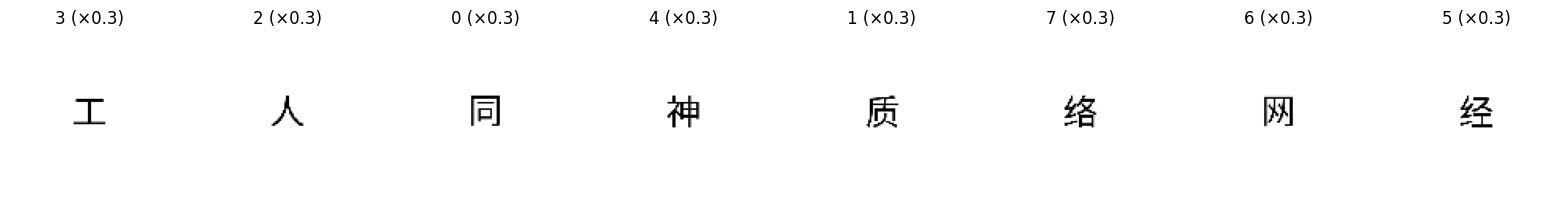

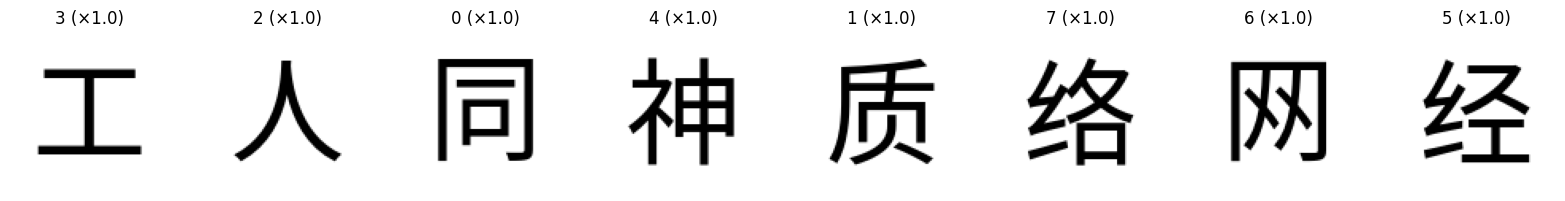

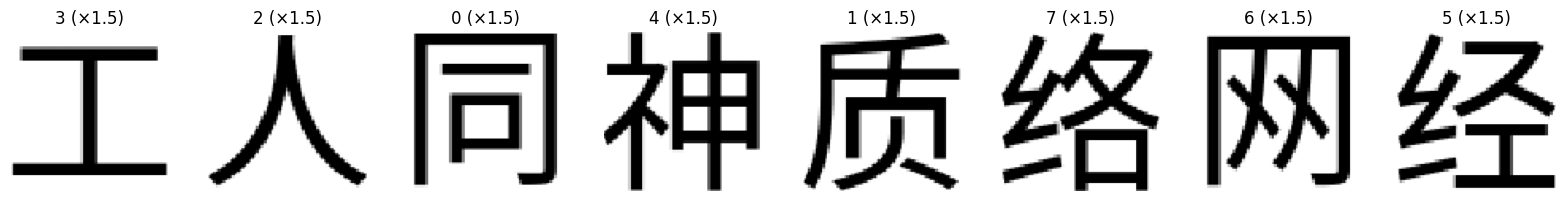

In [ ]:
for scale in scales:
    # Find max scale
    
    # Collect only the max scale images
    max_scale_images = [(r["label"], r["image"]) for r in records if r["scale"] == scale]
    
    # Plot them
    n = len(max_scale_images)
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 2))
    
    for ax, (label, img) in zip(axes, max_scale_images):
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"{label} (×{scale:.1f})")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


## test

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

r1, r2, r3, r4, r5, r6, r7, r8 = 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0
nu = 0.0
Gd = torch.diag(torch.tensor([r1 + 2, r2 + 2, r3 + 2, r4 + 2, r5 + 2, r6 + 2, r7 + 2, r8 + 2], device=device))
P  = torch.eye(8, device=device)
alpha, beta = compute_alpha_beta(Gd, P)
eigvals, eigvecs = torch.linalg.eig(Gd)
V = eigvecs.to(device)
V_inv = torch.linalg.inv(V).to(device)
lam = eigvals.to(device)

x_spheres = []

for i in range(8):
    df_test = df[df["label"]==i]
    X = torch.tensor(df_test[feature_columns].values, dtype=torch.float32, device=device)
    
    S = batch_bisection_solve_diag(lam, V, V_inv, P, X, alpha, beta, tol=1e-6, max_iter=1000)
    x_sphere = dilation_batch_diag(lam, V, V_inv, -S, X)
    
    x_spheres.append(x_sphere)
    
    norms = (x_sphere ** 2).sum(dim=1, keepdim=True)
    dists_squared = norms + norms.T - 2 * x_sphere @ x_sphere.T
    max_dist = torch.sqrt(dists_squared.max())
    print(f"[Label {i}] Max distance in x_sphere:", max_dist.item())

distance_matrix = torch.zeros((8, 8), device=device)

for i in range(8):
    for j in range(i + 1, 8):
        A, B = x_spheres[i], x_spheres[j]
        # broadcasting: (N_i, 1, d) - (1, N_j, d) -> (N_i, N_j, d)
        diff = A[:, None, :] - B[None, :, :]
        dists = torch.norm(diff, dim=2)  # (N_i, N_j)
        min_dist = dists.min()
        distance_matrix[i, j] = min_dist
        distance_matrix[j, i] = min_dist  # symétrie

# Affichage lisible
import pandas as pd
import numpy as np

# Conversion en DataFrame pour affichage clair
distance_df = pd.DataFrame(
    distance_matrix.cpu().numpy(),
    index=[f'label_{i}' for i in range(8)],
    columns=[f'label_{j}' for j in range(8)]
)

print("=== Distance minimale entre x_sphere de chaque paire de labels ===")
print(distance_df.round(6))


[Label 0] Max distance in x_sphere: 0.041675884276628494
[Label 1] Max distance in x_sphere: 0.03665851056575775
[Label 2] Max distance in x_sphere: 0.042571574449539185
[Label 3] Max distance in x_sphere: 0.11238691955804825
[Label 4] Max distance in x_sphere: 0.057168539613485336
[Label 5] Max distance in x_sphere: 0.030330481007695198
[Label 6] Max distance in x_sphere: 0.05737980082631111
[Label 7] Max distance in x_sphere: 0.02223959006369114
=== Distance minimale entre x_sphere de chaque paire de labels ===
          label_0   label_1   label_2   label_3   label_4   label_5   label_6  \
label_0  0.000000  0.080942  0.260856  0.124188  0.068801  0.140733  0.021470   
label_1  0.080942  0.000000  0.189426  0.110993  0.034944  0.053429  0.054360   
label_2  0.260856  0.189426  0.000000  0.086591  0.208897  0.130874  0.235789   
label_3  0.124188  0.110993  0.086591  0.000000  0.143595  0.118344  0.126872   
label_4  0.068801  0.034944  0.208897  0.143595  0.000000  0.066833  0.02678

## training HNN vs MLP

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- split by scale: train = {scale == 1}, test = {scale != 1} ---
mask_train = np.isclose(df["scale"].to_numpy(), 1.0)
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[~mask_train].reset_index(drop=True)

# Features/labels
X_train = torch.tensor(train_df[feature_columns].to_numpy(), dtype=torch.float32, device=device)
y_train = torch.tensor(train_df["label"].to_numpy(),            dtype=torch.long,   device=device)

X_test  = torch.tensor(test_df[feature_columns].to_numpy(),  dtype=torch.float32, device=device)
y_test  = torch.tensor(test_df["label"].to_numpy(),          dtype=torch.long,   device=device)

# Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test,  y_test)

# Loaders (full-batch train; adjust batch sizes as you like)
train_loader = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1024,          shuffle=False)


In [4]:
print(device)

cuda


In [ ]:
r1, r2, r3, r4, r5, r6, r7, r8 = 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0
nu = 0.0
Gd = torch.diag(torch.tensor([r1 + 2, r2 + 2, r3 + 2, r4 + 2, r5 + 2, r6 + 2, r7 + 2, r8 + 2], device=device))
P  = torch.eye(8, device=device)

# --- Define models ---
hidden_dim = 8
output_dim = 8

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu).to(device)

model_hnn.apply(initialize_weights)

# 2) Standard MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.name = 'MLP'
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizers ---
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-3, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-3, weight_decay=1e-4)

In [ ]:


def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Loss and optimizers ---
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-3, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(),  lr=1e-3, weight_decay=1e-4)

# --- Training with validation and test evaluations ---
num_epochs = 10000

train_loss_h = []
test_loss_h  = []
train_loss_m = []
test_loss_m  = []

train_acc_h = []
test_acc_h  = []
train_acc_m = []
test_acc_m  = []

for epoch in range(num_epochs):
    # Training phase
    model_hnn.train()
    model_mlp.train()
    running_h = 0.0
    running_m = 0.0

    for batch_x, batch_y in train_loader:
        # HomogeneousNN
        
        opt_hnn.zero_grad()
        pred_h = model_hnn(batch_x)
        loss_h = criterion(pred_h, batch_y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP
        opt_mlp.zero_grad()
        pred_m = model_mlp(batch_x)
        loss_m = criterion(pred_m, batch_y)
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    # Evaluation phase
    model_hnn.eval()
    model_mlp.eval()
    val_h, val_m = 0.0, 0.0
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            ph = model_hnn(bx)
            pm = model_mlp(bx)
            test_h += criterion(ph, by).item()
            test_m += criterion(pm, by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    # Compute accuracies
    train_acc_h.append(compute_accuracy(model_hnn, train_loader))
    test_acc_h.append(compute_accuracy(model_hnn, test_loader))
    train_acc_m.append(compute_accuracy(model_mlp, train_loader))
    test_acc_m.append(compute_accuracy(model_mlp, test_loader))

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:3d} | HNN Train: {train_loss_h[-1]:.4f} | Test: {test_loss_h[-1]:.4f} "
              f"|| MLP Train: {train_loss_m[-1]:.4f} | Test: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot loss curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot accuracy curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_h, label='HNN Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_h,  label='HNN Test Accuracy')
plt.plot(range(1, num_epochs+1), train_acc_m, label='MLP Train Accuracy', linestyle='--')
plt.plot(range(1, num_epochs+1), test_acc_m,  label='MLP Test Accuracy',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'model_hnn' is not defined

Param counts  |  hNN: (unknown)  MLP: 144  CNN: 228
Epoch 1000 | HNN T:1.3149/1.3245  MLP T:1.5036/1.6365  CNN T:1.7306/2.2462
Epoch 2000 | HNN T:0.7454/0.7666  MLP T:1.1883/1.7141  CNN T:1.6053/2.6320
Epoch 3000 | HNN T:0.4165/0.4638  MLP T:1.0499/1.5343  CNN T:1.5365/3.0510
Epoch 4000 | HNN T:0.2393/0.3077  MLP T:0.9220/1.7366  CNN T:1.4841/3.5513
Epoch 5000 | HNN T:0.1386/0.2224  MLP T:0.9075/1.8550  CNN T:1.4362/4.1480
Training complete.


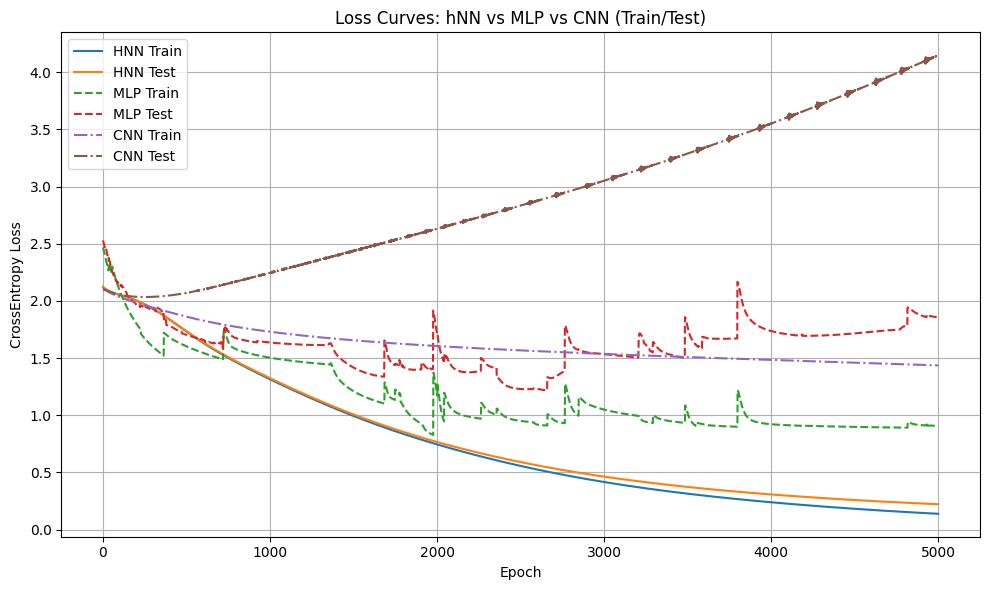

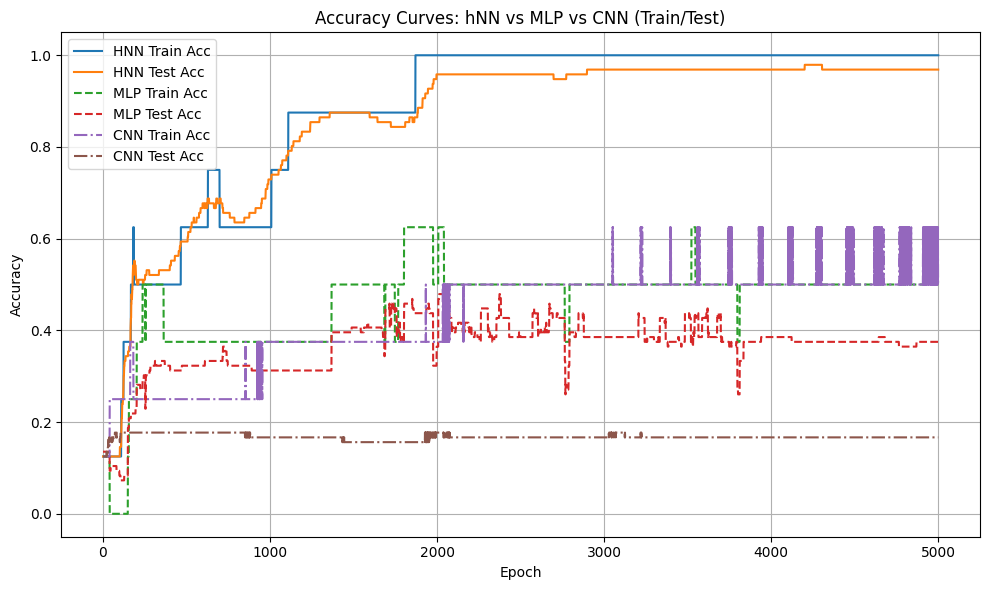

In [ ]:
# ===== 1) Image tensors & loaders for the CNN =====

def pil_to_tensor(img_pil):
    # same polarity as your phi: foreground ~1, background ~0
    arr = (255.0 - np.array(img_pil)) / 255.0   # (H, W)
    t = torch.from_numpy(arr).float().unsqueeze(0)  # (1, H, W)
    return t

X_img_all = torch.stack([pil_to_tensor(im) for im in df["image"]]).to(device)
y_all     = torch.tensor(df["label"].to_numpy(), dtype=torch.long, device=device)

mask_train = np.isclose(df["scale"].to_numpy(), 1.0)
X_img_train = X_img_all[mask_train]
y_img_train = y_all[mask_train]
X_img_test  = X_img_all[~mask_train]
y_img_test  = y_all[~mask_train]

train_img_ds = TensorDataset(X_img_train, y_img_train)
test_img_ds  = TensorDataset(X_img_test,  y_img_test)

# full-batch train for fair stats; tweak if needed
train_loader_img = DataLoader(train_img_ds, batch_size=len(train_img_ds), shuffle=True)
test_loader_img  = DataLoader(test_img_ds,  batch_size=1024,               shuffle=False)

# Optional: compute per-channel mean/std from training images and normalize in loader
img_mean = X_img_train.mean()
img_std  = X_img_train.std() + 1e-8

class ImgNormLoader:
    def __init__(self, loader, mean, std):
        self.loader, self.mean, self.std = loader, mean, std
    def __iter__(self):
        for x, y in self.loader:
            yield ((x - self.mean) / self.std, y)
    def __len__(self): return len(self.loader)

train_loader_img_n = ImgNormLoader(train_loader_img, img_mean, img_std)
test_loader_img_n  = ImgNormLoader(test_loader_img,  img_mean, img_std)

# ===== 2) A tiny CNN (≈228 params with 4 channels) =====
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8, channels=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, channels, kernel_size=3, padding=1, bias=True),  # params: 4*1*3*3+4 = 40
            nn.Tanh(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=True),  # params: 4*4*3*3+4 = 148
            nn.Tanh(),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)   # no params
        self.classifier = nn.Linear(channels, num_classes)  # 4*8 + 8 = 40

    def forward(self, x):
        z = self.features(x)
        z = self.gap(z).squeeze(-1).squeeze(-1)  # (B, C)
        return self.classifier(z)

model_cnn = SimpleCNN(num_classes=8, channels=4).to(device)

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)
print("Param counts  |  hNN: (unknown)  MLP:", count_params(model_mlp), " CNN:", count_params(model_cnn))

# ===== 3) Add CNN to loss/optim and training bookkeeping =====
criterion = nn.CrossEntropyLoss()
opt_cnn = optim.Adam(model_cnn.parameters(), lr=1e-3, weight_decay=1e-4)

train_loss_c, test_loss_c = [], []
train_acc_c,  test_acc_c  = [], []
train_loss_h = []
test_loss_h  = []
train_loss_m = []
test_loss_m  = []

train_acc_h = []
test_acc_h  = []
train_acc_m = []
test_acc_m  = []

# keep your existing lists for hNN/MLP...

def compute_accuracy(model, loader):
    correct = 0; total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total   += y.size(0)
    return correct / total

# ===== 4) Update your training loop to include CNN =====
num_epochs = 5000
for epoch in range(num_epochs):
    model_hnn.train(); model_mlp.train(); model_cnn.train()
    running_h = running_m = running_c = 0.0

    # one full-batch from each loader (your loaders are full-batch)
    (x_feat, y_feat) = next(iter(train_loader))       # features for hNN/MLP
    (x_img,  y_img)  = next(iter(train_loader_img_n)) # images for CNN (normalized)

    # --- hNN ---
    opt_hnn.zero_grad()
    loss_h = criterion(model_hnn(x_feat), y_feat)
    loss_h.backward(); opt_hnn.step()
    running_h += loss_h.item()

    # --- MLP ---
    opt_mlp.zero_grad()
    loss_m = criterion(model_mlp(x_feat), y_feat)
    loss_m.backward(); opt_mlp.step()
    running_m += loss_m.item()

    # --- CNN ---
    opt_cnn.zero_grad()
    loss_c = criterion(model_cnn(x_img), y_img)
    loss_c.backward(); opt_cnn.step()
    running_c += loss_c.item()

    # record train losses
    train_loss_h.append(running_h)
    train_loss_m.append(running_m)
    train_loss_c.append(running_c)

    # ----- evaluation -----
    model_hnn.eval(); model_mlp.eval(); model_cnn.eval()
    th = tm = tc = 0.0

    with torch.no_grad():
        # features loaders
        for bx, by in test_loader:
            th += criterion(model_hnn(bx), by).item()
            tm += criterion(model_mlp(bx), by).item()
        # image loader
        for bx, by in test_loader_img_n:
            tc += criterion(model_cnn(bx), by).item()

    test_loss_h.append(th / len(test_loader))
    test_loss_m.append(tm / len(test_loader))
    test_loss_c.append(tc / len(test_loader_img_n))

    # accuracies
    train_acc_h.append(compute_accuracy(model_hnn, train_loader))
    test_acc_h.append(compute_accuracy(model_hnn,  test_loader))
    train_acc_m.append(compute_accuracy(model_mlp, train_loader))
    test_acc_m.append(compute_accuracy(model_mlp,  test_loader))
    train_acc_c.append(compute_accuracy(model_cnn, train_loader_img_n))
    test_acc_c.append(compute_accuracy(model_cnn,  test_loader_img_n))

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:4d} | HNN T:{train_loss_h[-1]:.4f}/{test_loss_h[-1]:.4f}  "
              f"MLP T:{train_loss_m[-1]:.4f}/{test_loss_m[-1]:.4f}  "
              f"CNN T:{train_loss_c[-1]:.4f}/{test_loss_c[-1]:.4f}")

print("Training complete.")

# ===== 5) Plots with CNN curves =====
epochs = range(1, num_epochs+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_h, label='HNN Train')
plt.plot(epochs, test_loss_h,  label='HNN Test')
plt.plot(epochs, train_loss_m, label='MLP Train', linestyle='--')
plt.plot(epochs, test_loss_m,  label='MLP Test',  linestyle='--')
plt.plot(epochs, train_loss_c, label='CNN Train', linestyle='-.')
plt.plot(epochs, test_loss_c,  label='CNN Test',  linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('CrossEntropy Loss')
plt.title('Loss Curves: hNN vs MLP vs CNN (Train/Test)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_h, label='HNN Train Acc')
plt.plot(epochs, test_acc_h,  label='HNN Test Acc')
plt.plot(epochs, train_acc_m, label='MLP Train Acc', linestyle='--')
plt.plot(epochs, test_acc_m,  label='MLP Test Acc',  linestyle='--')
plt.plot(epochs, train_acc_c, label='CNN Train Acc', linestyle='-.')
plt.plot(epochs, test_acc_c,  label='CNN Test Acc',  linestyle='-.')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy Curves: hNN vs MLP vs CNN (Train/Test)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


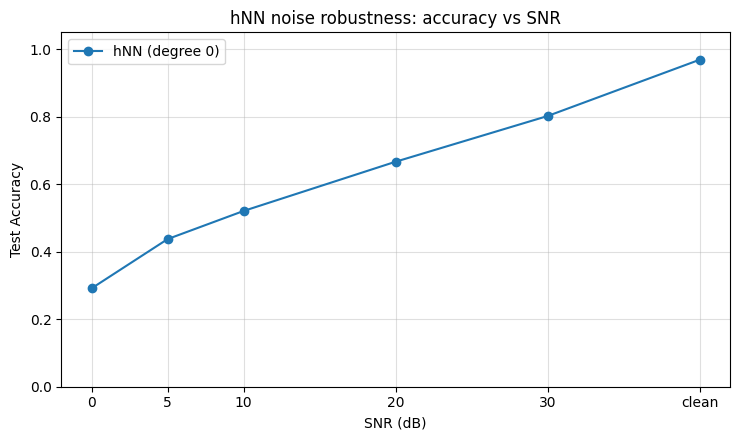

In [ ]:
def _pil_to_phi(img_pil):
    # same polarity used earlier: foreground ~ 1, background ~ 0
    arr = (255.0 - np.array(img_pil)) / 255.0  # (H, W) in [0,1]
    return arr.astype(np.float32)

@torch.no_grad()
def evaluate_hnn_accuracy_vs_snr(
    model_hnn,
    df,
    compute_basis_vector,
    device,
    snr_db_grid=(np.inf, 30, 20, 10, 5, 0),
    per_image_signal_power=True,
    feature_dim=8,
):
    """
    Returns: snr_db_grid (list), acc (list in [0,1])
    """
    model_hnn.eval()

    # ---- test split: all zoomed scales (scale != 1.0) ----
    mask_test = ~np.isclose(df["scale"].to_numpy(), 1.0)
    images = [df.loc[i, "image"] for i in np.where(mask_test)[0]]
    labels = df.loc[mask_test, "label"].to_numpy().astype(np.int64)

    # Precompute signal powers (mean of squares) if per-image
    phis = [_pil_to_phi(im) for im in images]
    if per_image_signal_power:
        P_sig = np.array([np.mean(phi**2) for phi in phis], dtype=np.float32)
    else:
        P_sig = np.full(len(phis), np.mean([np.mean(phi**2) for phi in phis]), dtype=np.float32)

    accs = []
    for snr_db in snr_db_grid:
        feats = np.zeros((len(phis), feature_dim), dtype=np.float32)

        for i, phi in enumerate(phis):
            if np.isinf(snr_db):
                noisy = phi  # clean
            else:
                sigma = np.sqrt(P_sig[i] * 10.0 ** (-snr_db / 10.0))
                noisy = np.clip(phi + np.random.normal(0.0, sigma, size=phi.shape), 0.0, 1.0).astype(np.float32)

            feats[i, :] = compute_basis_vector(noisy)

        X = torch.tensor(feats, dtype=torch.float32, device=device)
        y = torch.tensor(labels, dtype=torch.long, device=device)
        logits = model_hnn(X)
        preds = logits.argmax(dim=1)
        acc = (preds == y).float().mean().item()
        accs.append(acc)

    return list(snr_db_grid), accs

# ---- run + plot ----
snr_db_grid, accs_hnn = evaluate_hnn_accuracy_vs_snr(
    model_hnn=model_hnn,
    df=df,
    compute_basis_vector=compute_basis_vector,
    device=device,
    snr_db_grid=(np.inf, 30, 20, 10, 5, 0),  # edit as desired
)

# Nice x-axis with "clean" for ∞
finite = [s for s in snr_db_grid if np.isfinite(s)]
x_plot = [(max(finite) + 10) if not np.isfinite(s) else s for s in snr_db_grid]
xticks = x_plot
xticklabels = ["clean" if not np.isfinite(s) else f"{int(s)}" for s in snr_db_grid]

plt.figure(figsize=(7.5, 4.5))
plt.plot(x_plot, accs_hnn, marker="o", label="hNN (degree 0)")
plt.xticks(xticks, xticklabels)
plt.xlabel("SNR (dB)")
plt.ylabel("Test Accuracy")
plt.title("hNN noise robustness: accuracy vs SNR")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


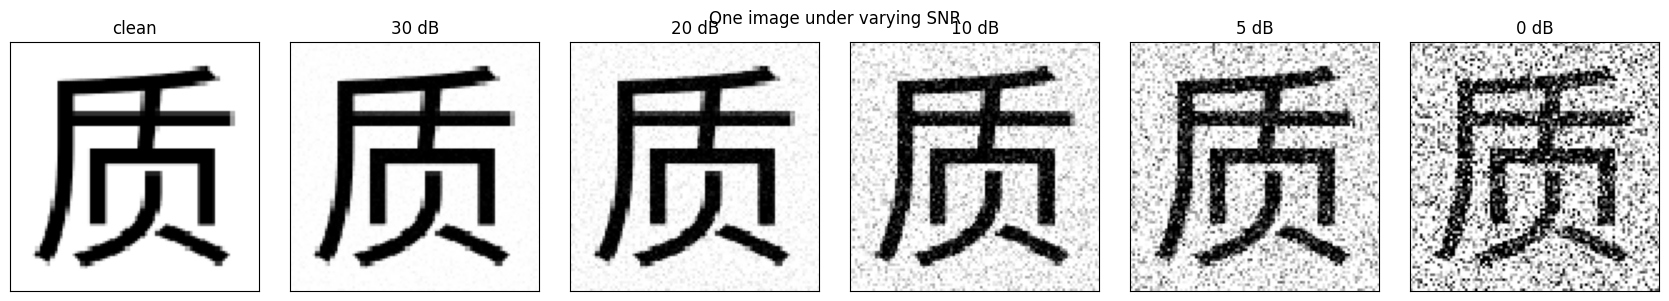

In [ ]:
def _pil_to_phi(img_pil):
    arr = (255.0 - np.array(img_pil)) / 255.0  # [0,1], foreground≈1
    return arr.astype(np.float32)

def show_image_across_snr(df, snr_db_list=(np.inf, 30, 20, 10, 5, 0), idx=None, seed=0):
    """
    Show the same test image at multiple SNRs on one figure.
    - df: your DataFrame with columns ['image','scale', ...]
    - snr_db_list: iterable like (inf,30,20,10,5,0)
    - idx: optional integer index into the test subset (scale != 1.0). If None, pick the first one.
    """
    rng = np.random.default_rng(seed)

    # pick a test image (any scale != 1.0)
    mask_test = ~np.isclose(df["scale"].to_numpy(), 1.0)
    test_idxs = np.where(mask_test)[0]
    if len(test_idxs) == 0:
        raise ValueError("No test images with scale != 1.0 found.")
    if idx is None:
        idx = int(test_idxs[8])
    elif idx not in test_idxs:
        raise ValueError("Provided idx is not a test image (scale != 1.0).")

    img = df.loc[idx, "image"]
    phi = _pil_to_phi(img)  # clean in [0,1]
    P_sig = float(np.mean(phi**2))  # signal power

    n = len(snr_db_list)
    fig, axes = plt.subplots(1, n, figsize=(2.8*n, 2.8), constrained_layout=True)

    if n == 1:
        axes = [axes]

    for ax, snr_db in zip(axes, snr_db_list):
        if np.isinf(snr_db):
            noisy = phi
            title = "clean"
        else:
            sigma = np.sqrt(P_sig * 10.0**(-snr_db/10.0))
            noise = rng.normal(0.0, sigma, size=phi.shape).astype(np.float32)
            noisy = np.clip(phi + noise, 0.0, 1.0)
            title = f"{int(snr_db)} dB"

        ax.imshow(1.0 - noisy, cmap="gray", vmin=0.0, vmax=1.0)
        ax.set_title(title)
        ax.set_xticks([]); ax.set_yticks([])

    fig.suptitle("One image under varying SNR", y=1.02)
    plt.show()

# Example call:
show_image_across_snr(df, snr_db_list=(np.inf, 30, 20, 10, 5, 0), idx=None, seed=42)


## training HNN vs MLP with normalized data 

Epoch 1000 | HNN Train Loss: 1.3156 | Test Loss: 1.3252 || MLP Train Loss: 2.1198 | Test Loss: 2.2411
Epoch 2000 | HNN Train Loss: 0.7459 | Test Loss: 0.7670 || MLP Train Loss: 2.0781 | Test Loss: 2.2215
Epoch 3000 | HNN Train Loss: 0.4167 | Test Loss: 0.4640 || MLP Train Loss: 2.0583 | Test Loss: 2.2406
Epoch 4000 | HNN Train Loss: 0.2394 | Test Loss: 0.3078 || MLP Train Loss: 2.0481 | Test Loss: 2.2281
Epoch 5000 | HNN Train Loss: 0.1387 | Test Loss: 0.2224 || MLP Train Loss: 2.0912 | Test Loss: 2.2126
Epoch 6000 | HNN Train Loss: 0.0816 | Test Loss: 0.1757 || MLP Train Loss: 2.0764 | Test Loss: 2.2310
Epoch 7000 | HNN Train Loss: 0.0517 | Test Loss: 0.1521 || MLP Train Loss: 2.0784 | Test Loss: 2.2042
Epoch 8000 | HNN Train Loss: 0.0369 | Test Loss: 0.1418 || MLP Train Loss: 2.0276 | Test Loss: 2.2583
Epoch 9000 | HNN Train Loss: 0.0299 | Test Loss: 0.1393 || MLP Train Loss: 2.0752 | Test Loss: 2.2205
Epoch 10000 | HNN Train Loss: 0.0266 | Test Loss: 0.1417 || MLP Train Loss: 2.0573

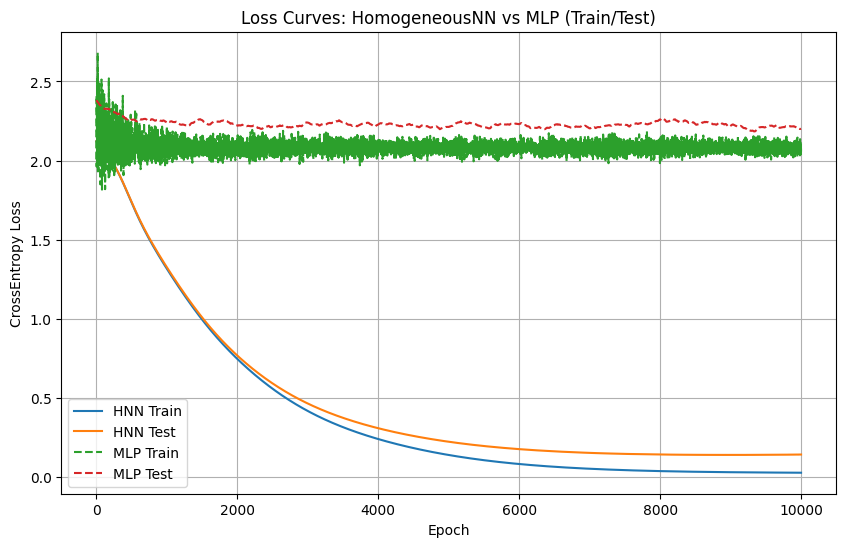

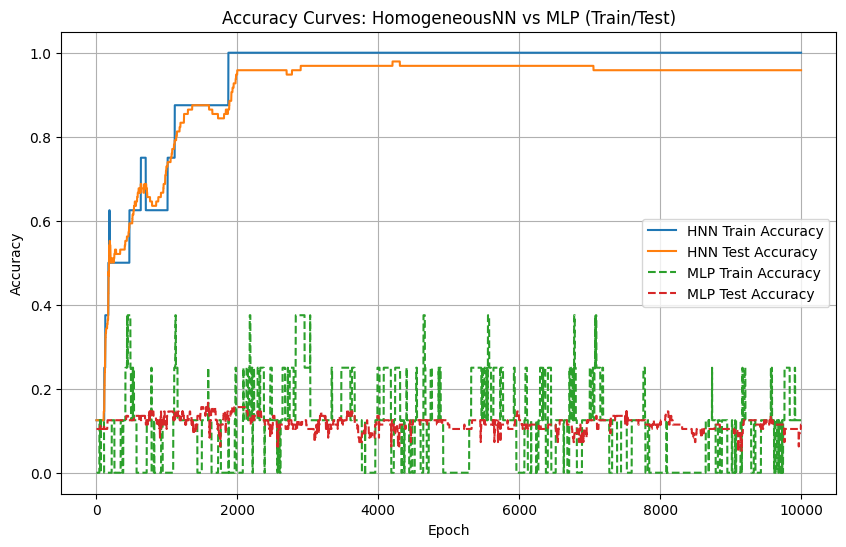

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_columns = [f"x{i+1}" for i in range(8)]  # if not already defined

mask_train = np.isclose(df["scale"].to_numpy(), 1.0)
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[~mask_train].reset_index(drop=True)

X_train = torch.tensor(train_df[feature_columns].to_numpy(), dtype=torch.float32, device=device)
y_train = torch.tensor(train_df["label"].to_numpy(),            dtype=torch.long,   device=device)

X_test  = torch.tensor(test_df[feature_columns].to_numpy(),  dtype=torch.float32, device=device)
y_test  = torch.tensor(test_df["label"].to_numpy(),          dtype=torch.long,   device=device)

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test,  y_test)

# full-batch train (so mean/std below covers all train samples); tweak if you want mini-batches
train_loader = DataLoader(train_ds, batch_size=len(train_ds), shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1024,         shuffle=False)

# --- Compute normalization stats from training data ---
mean = X_train.mean(dim=0, keepdim=True)
std  = X_train.std(dim=0, keepdim=True) + 1e-8

# --- Normalized DataLoader wrapper (unchanged) ---
class NormalizedLoaderWrapper:
    def __init__(self, loader, mean, std):
        self.loader, self.mean, self.std = loader, mean, std
    def __iter__(self):
        for x, y in self.loader:
            yield ((x - self.mean) / self.std, y)
    def __len__(self): return len(self.loader)

train_loader_mlp = NormalizedLoaderWrapper(train_loader, mean, std)
test_loader_mlp  = NormalizedLoaderWrapper(test_loader,  mean, std)

# --- Model definitions ---
r1, r2, r3, r4, r5, r6, r7, r8 = 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0
nu = 0.0
Gd = torch.diag(torch.tensor([r1 + 2, r2 + 2, r3 + 2, r4 + 2, r5 + 2, r6 + 2, r7 + 2, r8 + 2], device=device))
P = torch.eye(8, device=device)

hidden_dim = 8
output_dim = 8

model_hnn = HomogeneousNN(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim,
                          P=P, Gd=Gd, nu=nu).to(device)
model_hnn.apply(initialize_weights)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizers ---
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-3, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=1e-4)

# --- Accuracy function ---
def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Training ---
num_epochs = 10000
train_loss_h, test_loss_h = [], []
train_loss_m, test_loss_m = [], []
train_acc_h, test_acc_h = [], []
train_acc_m, test_acc_m = [], []

for epoch in range(num_epochs):
    model_hnn.train()
    model_mlp.train()
    running_h, running_m = 0.0, 0.0

    for (x_hnn, y), (x_mlp, _) in zip(train_loader, train_loader_mlp):
        # HNN
        opt_hnn.zero_grad()
        pred_h = model_hnn(x_hnn)
        loss_h = criterion(pred_h, y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP
        opt_mlp.zero_grad()
        pred_m = model_mlp(x_mlp)
        loss_m = criterion(pred_m, y)
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    model_hnn.eval()
    model_mlp.eval()
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            test_h += criterion(model_hnn(bx), by).item()
        for bx, by in test_loader_mlp:
            test_m += criterion(model_mlp(bx), by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    # Accuracies
    train_acc_h.append(compute_accuracy(model_hnn, train_loader))
    test_acc_h.append(compute_accuracy(model_hnn, test_loader))
    train_acc_m.append(compute_accuracy(model_mlp, train_loader_mlp))
    test_acc_m.append(compute_accuracy(model_mlp, test_loader_mlp))

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:4d} | HNN Train Loss: {train_loss_h[-1]:.4f} | Test Loss: {test_loss_h[-1]:.4f}"
              f" || MLP Train Loss: {train_loss_m[-1]:.4f} | Test Loss: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_h, label='HNN Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_h,  label='HNN Test Accuracy')
plt.plot(range(1, num_epochs+1), train_acc_m, label='MLP Train Accuracy', linestyle='--')
plt.plot(range(1, num_epochs+1), test_acc_m,  label='MLP Test Accuracy',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# Zooming and rotating pattern recognition

In [ ]:
# Define input
input_dir = "./data/chinese_chars_100x100"
scales = [0.3 + 0.1 * i for i in range(13)]
angles = np.arange(0,360,20)

records = []

for fname in os.listdir(input_dir):
    if fname.lower().endswith(".png"):
        img_path = os.path.join(input_dir, fname)
        label = int(os.path.splitext(fname)[0].split("_")[0])
        original = PILImage.open(img_path).convert("L")

        for scale in scales:
            new_size = (int(100 * scale), int(100 * scale))
            resized = original.resize(new_size, resample=PILImage.NEAREST)

            if scale < 1.0:
                canvas = PILImage.new("L", (100, 100), color=255)
                offset = ((100 - new_size[0]) // 2, (100 - new_size[1]) // 2)
                canvas.paste(resized, offset)
            elif scale > 1.0:
                left = (new_size[0] - 100) // 2
                top = (new_size[1] - 100) // 2
                canvas = resized.crop((left, top, left + 100, top + 100))
            else:
                canvas = original.copy()

            for angle in angles:
                rotated = canvas.rotate(angle, resample=PILImage.NEAREST, expand=False, fillcolor=255)

                phi = (255.0 - np.array(rotated)) / 255.0
                vec = compute_basis_vector(phi)

                records.append({
                    "label": label,
                    "scale": scale,
                    "angle": angle,
                    "features": vec,
                    "image": rotated.copy()
                })

# Convert to DataFrame
df = pd.DataFrame(records)
feature_columns = [f"x{i+1}" for i in range(8)]
df[feature_columns] = pd.DataFrame(df["features"].tolist(), index=df.index)


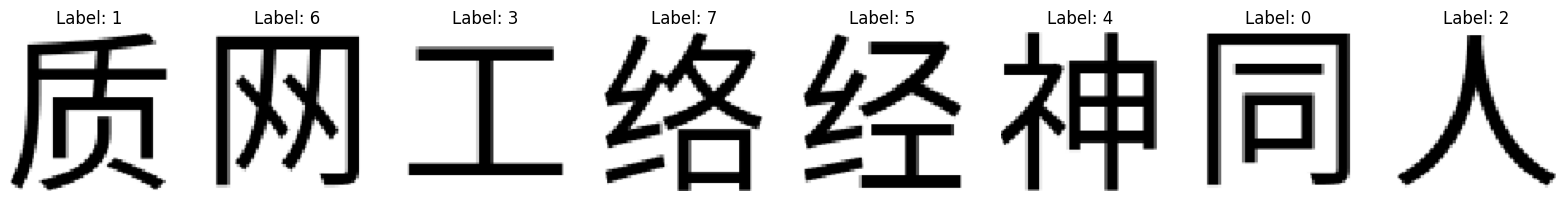

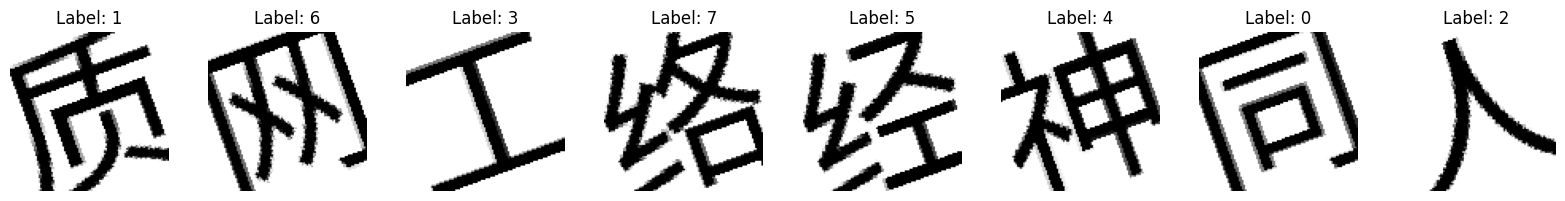

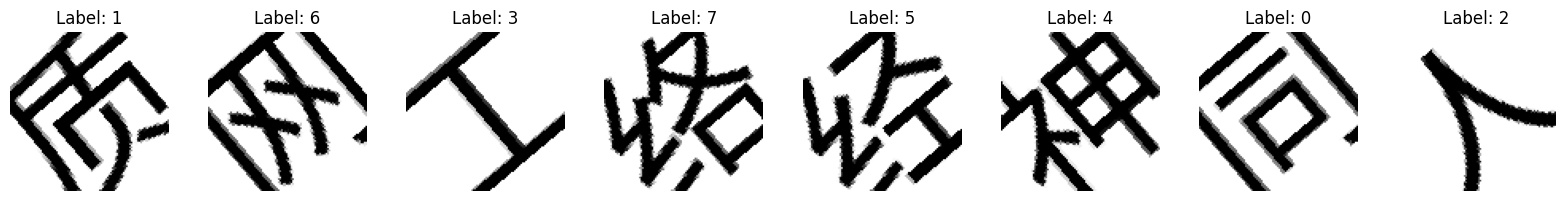

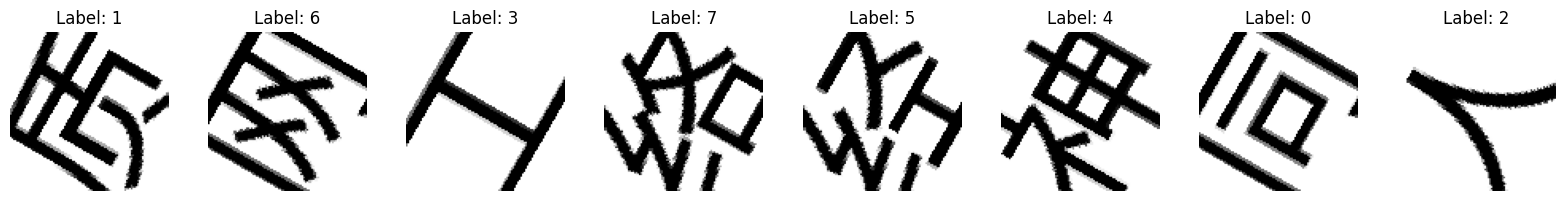

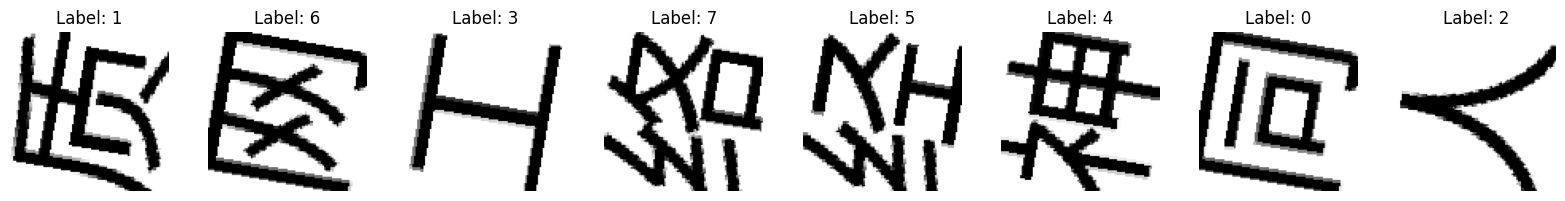

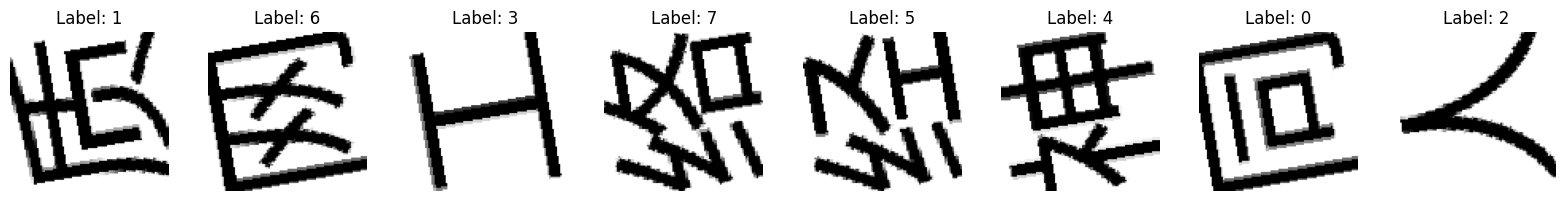

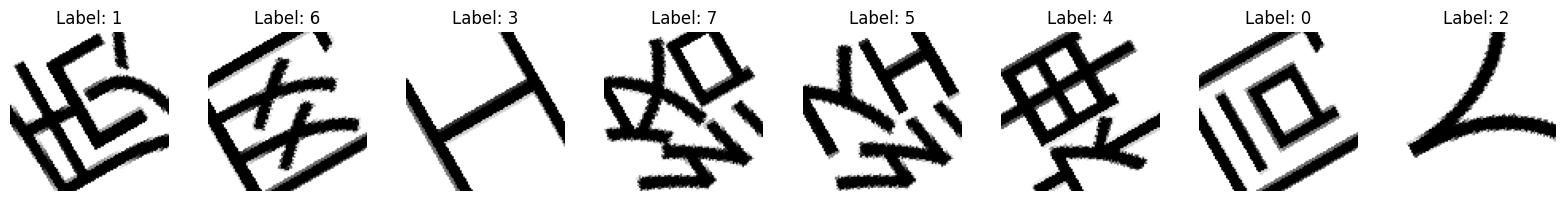

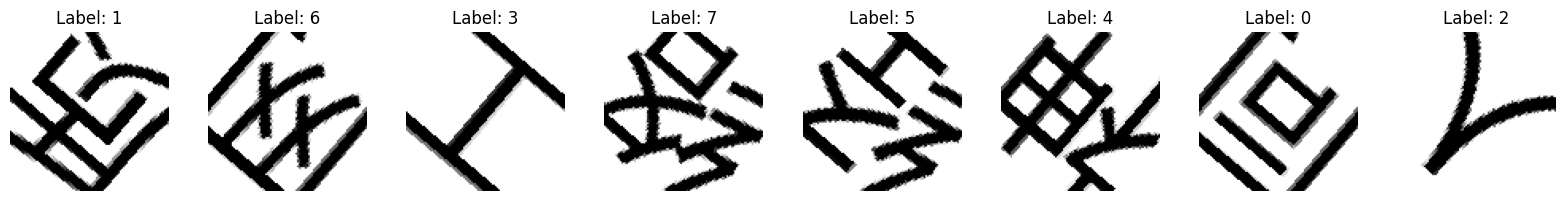

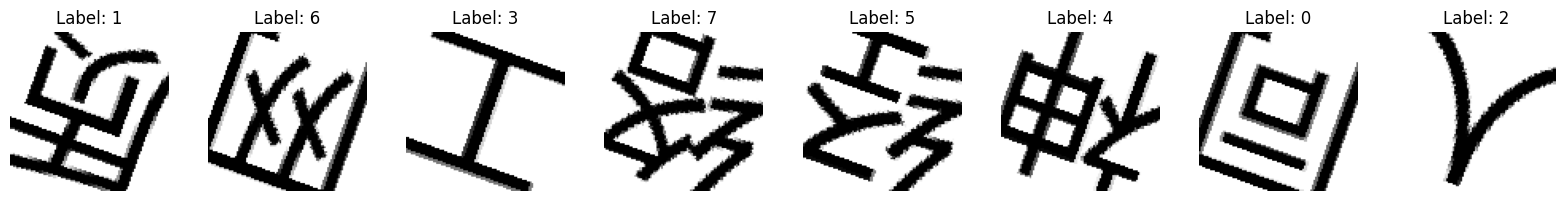

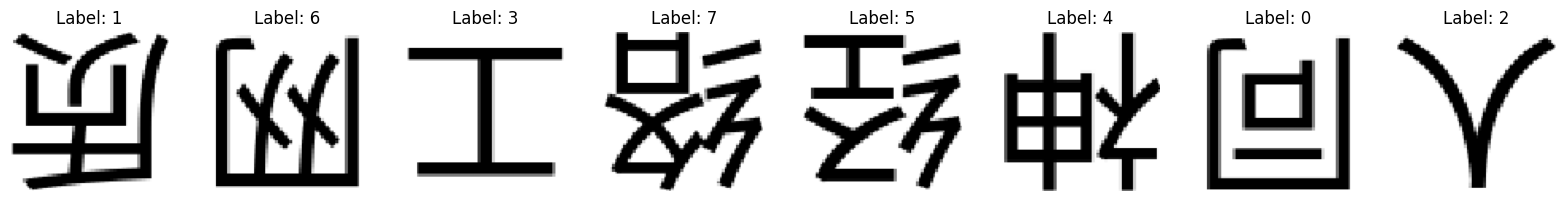

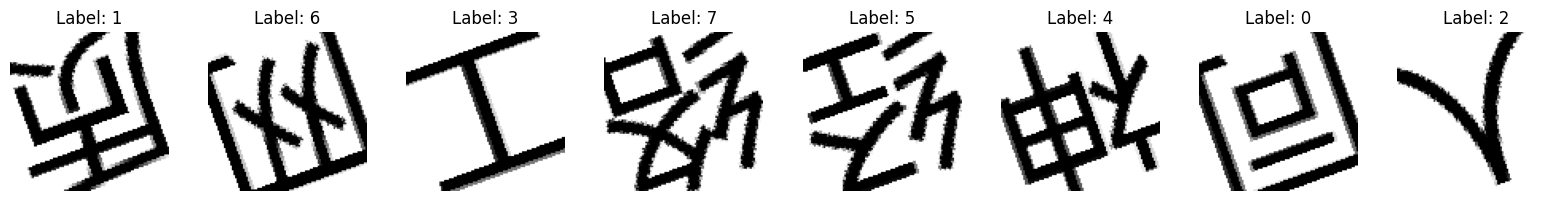

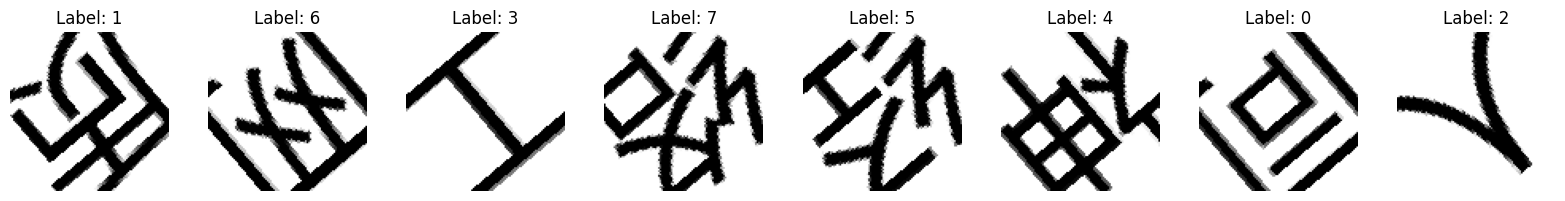

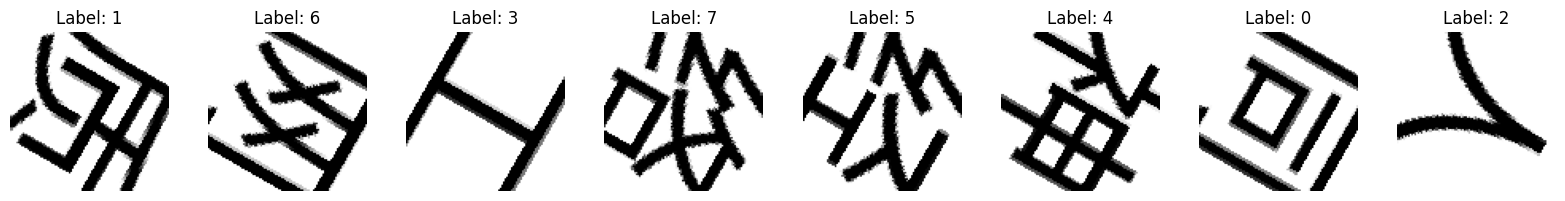

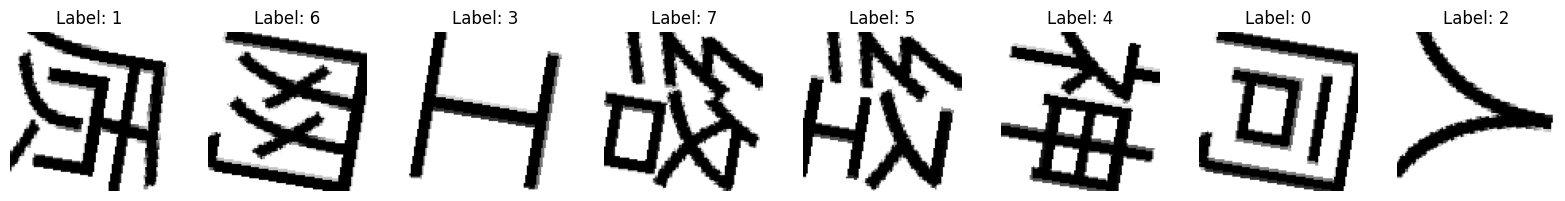

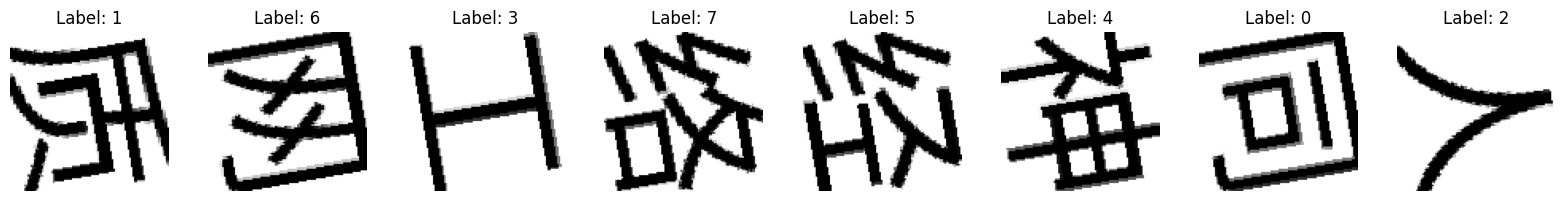

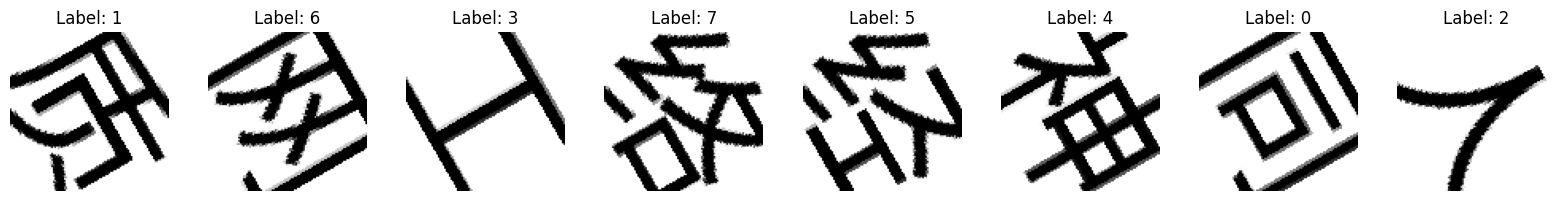

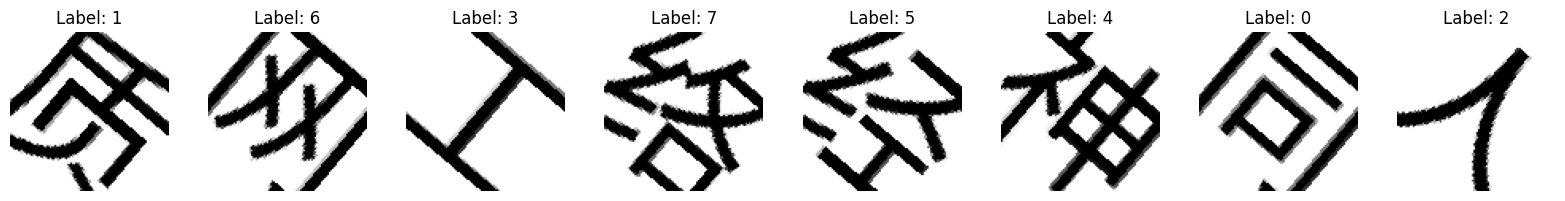

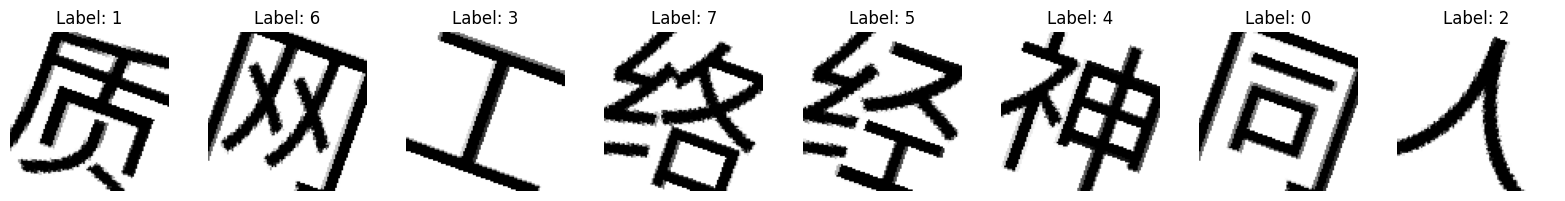

In [ ]:
# Pick a subset of the dataset to visualize: one image per label at the largest scale and 0° rotation
for angle in angles:
    sample_images = []
    seen_labels = set()
    
    for record in records:
        if (record["scale"] == max(scales)) and (record["angle"] == angle):
            label = record["label"]
            if label not in seen_labels:
                sample_images.append((label, record["image"]))
                seen_labels.add(label)
    
    # Plot the selected images
    n = len(sample_images)
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 2))
    
    for ax, (label, img) in zip(axes, sample_images):
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Prepare X (features) and y (one-hot)
X = torch.tensor(df[feature_columns].values, dtype=torch.float32, device = device)
y = torch.tensor(df["label"].values, dtype=torch.long, device = device)

full_dataset = TensorDataset(X, y)

train_size = int(0.5 * len(df))
test_size  = len(df) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])
batch_size = train_size

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

Epoch 1000 | HNN Train Loss: 1.7115 | Test Loss: 1.7174 || MLP Train Loss: 1.7391 | Test Loss: 1.8397
Epoch 2000 | HNN Train Loss: 1.3945 | Test Loss: 1.3960 || MLP Train Loss: 1.4041 | Test Loss: 1.5337
Epoch 3000 | HNN Train Loss: 1.1860 | Test Loss: 1.1869 || MLP Train Loss: 1.2369 | Test Loss: 1.4191
Epoch 4000 | HNN Train Loss: 1.0231 | Test Loss: 1.0286 || MLP Train Loss: 1.0855 | Test Loss: 1.3152
Epoch 5000 | HNN Train Loss: 0.8535 | Test Loss: 0.8616 || MLP Train Loss: 0.9865 | Test Loss: 1.2375
Epoch 6000 | HNN Train Loss: 0.7065 | Test Loss: 0.7228 || MLP Train Loss: 0.9443 | Test Loss: 1.2130
Epoch 7000 | HNN Train Loss: 0.5963 | Test Loss: 0.6228 || MLP Train Loss: 0.9111 | Test Loss: 1.2213
Epoch 8000 | HNN Train Loss: 0.5193 | Test Loss: 0.5541 || MLP Train Loss: 0.8888 | Test Loss: 1.2207
Epoch 9000 | HNN Train Loss: 0.4653 | Test Loss: 0.5063 || MLP Train Loss: 0.8722 | Test Loss: 1.2219
Epoch 10000 | HNN Train Loss: 0.4262 | Test Loss: 0.4716 || MLP Train Loss: 0.8587

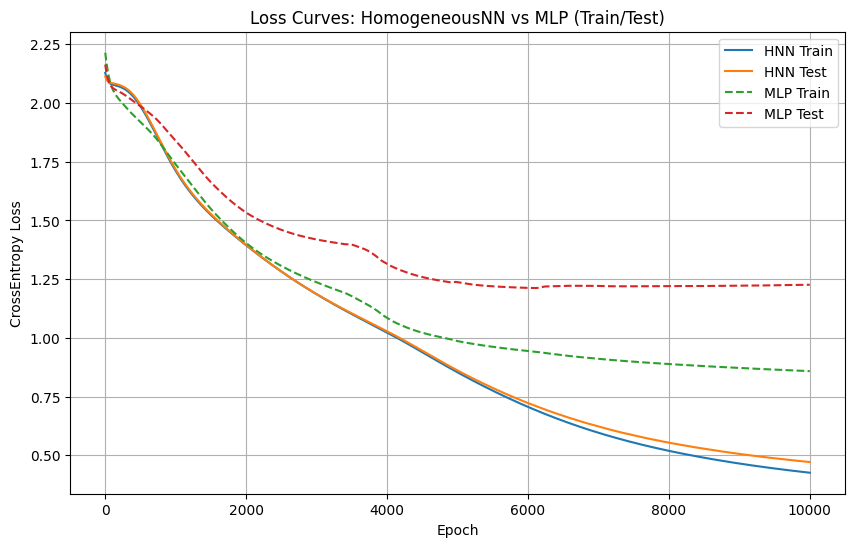

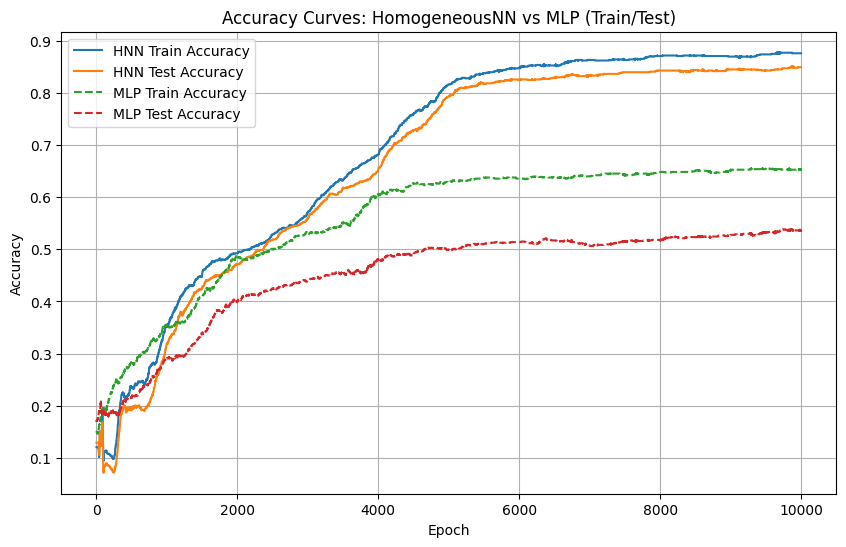

In [ ]:
# --- Device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Prepare dataset ---
X = torch.tensor(df[feature_columns].values, dtype=torch.float32, device=device)
y = torch.tensor(df["label"].values, dtype=torch.long, device=device)

full_dataset = TensorDataset(X, y)

train_size = int(0.5 * len(df))
test_size = len(df) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])
batch_size = train_size

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# --- Compute normalization stats from training data ---
train_X, _ = next(iter(train_loader))
mean = train_X.mean(dim=0, keepdim=True)
std = train_X.std(dim=0, keepdim=True) + 1e-8

# --- Normalized DataLoader wrapper ---
class NormalizedLoaderWrapper:
    def __init__(self, loader, mean, std):
        self.loader = loader
        self.mean = mean
        self.std = std

    def __iter__(self):
        for x, y in self.loader:
            yield (self.normalize(x), y)

    def __len__(self):
        return len(self.loader)

    def normalize(self, x):
        return (x - self.mean) / self.std

train_loader_mlp = NormalizedLoaderWrapper(train_loader, mean, std)
test_loader_mlp = NormalizedLoaderWrapper(test_loader, mean, std)

# --- Model definitions ---
r1, r2, r3, r4, r5, r6, r7, r8 = 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0
nu = 0.0
Gd = torch.diag(torch.tensor([r1 + 2, r2 + 2, r3 + 2, r4 + 2, r5 + 2, r6 + 2, r7 + 2, r8 + 2], device=device))
P = torch.eye(8, device=device)

hidden_dim = 8
output_dim = 8

model_hnn = HomogeneousNN(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim,
                          P=P, Gd=Gd, nu=nu).to(device)
model_hnn.apply(initialize_weights)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizers ---
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-3, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=1e-4)

# --- Accuracy function ---
def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Training ---
num_epochs = 10000
train_loss_h, test_loss_h = [], []
train_loss_m, test_loss_m = [], []
train_acc_h, test_acc_h = [], []
train_acc_m, test_acc_m = [], []

for epoch in range(num_epochs):
    model_hnn.train()
    model_mlp.train()
    running_h, running_m = 0.0, 0.0

    for (x_hnn, y), (x_mlp, _) in zip(train_loader, train_loader_mlp):
        # HNN
        opt_hnn.zero_grad()
        pred_h = model_hnn(x_hnn)
        loss_h = criterion(pred_h, y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP
        opt_mlp.zero_grad()
        pred_m = model_mlp(x_mlp)
        loss_m = criterion(pred_m, y)
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    model_hnn.eval()
    model_mlp.eval()
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            test_h += criterion(model_hnn(bx), by).item()
        for bx, by in test_loader_mlp:
            test_m += criterion(model_mlp(bx), by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    # Accuracies
    train_acc_h.append(compute_accuracy(model_hnn, train_loader))
    test_acc_h.append(compute_accuracy(model_hnn, test_loader))
    train_acc_m.append(compute_accuracy(model_mlp, train_loader_mlp))
    test_acc_m.append(compute_accuracy(model_mlp, test_loader_mlp))

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:4d} | HNN Train Loss: {train_loss_h[-1]:.4f} | Test Loss: {test_loss_h[-1]:.4f}"
              f" || MLP Train Loss: {train_loss_m[-1]:.4f} | Test Loss: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_h, label='HNN Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_h,  label='HNN Test Accuracy')
plt.plot(range(1, num_epochs+1), train_acc_m, label='MLP Train Accuracy', linestyle='--')
plt.plot(range(1, num_epochs+1), test_acc_m,  label='MLP Test Accuracy',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# Homogeneous rotation basis

Dilation + rotation: $d(s) = e^as R(\omega s)$ with 

$R(\omega s) = 
\begin{bmatrix}
\cos(\omega s) & -\sin(\omega s) \\
\sin(\omega s) & \cos(\omega s)
\end{bmatrix}
$
We can write: $d(s) = e^{sG_d}$ with $G_d = 
\begin{bmatrix}
a & -\omega \\
\omega & a
\end{bmatrix}
$

For this transformation 
$
x_i(\phi) = \int_{\mathbb{R}^2} b_i(z)\, \phi(z)\, dz, \quad i = 1, 2, \dots, n
$ to be homogeneous under $d$ we need $b_i$ homogeneous under $d$


In [ ]:
def compute_h_basis_vector(phi, nu=1.0, a=1.0, omega=3.0):
    """
    Computes the vector x = (x1, ..., x8) using generalized log-polar basis functions.

    Parameters:
        phi (np.ndarray): 2D array (100x100) with values in [0, 1] (grayscale intensities)
        nu (float): scaling parameter for r
        a (float): dilation parameter
        omega (float): frequency parameter for angular log modulation

    Returns:
        np.ndarray: shape (8,) vector
    """
    assert phi.shape == (100, 100), "Image must be 100x100"

    # Coordinate grid centered at (0,0)
    k = np.arange(100) - 50
    j = np.arange(100) - 50
    X, Y = np.meshgrid(k, j, indexing="ij")

    # Polar coordinates
    r = np.sqrt(X**2 + Y**2) + 1e-8  # avoid log(0)
    theta = np.arctan2(Y, X)

    # Argument to H (e.g., sinusoidal modulations)
    arg = theta - (omega / a) * np.log(r)

    # Choose angular basis H_k: here cosine and sine harmonics
    H_funcs = [
        lambda arg: np.ones_like(arg),              # H0: constant
        lambda arg: np.cos(arg),                    # H1
        lambda arg: np.sin(arg),                    # H2
        lambda arg: np.cos(2 * arg),                # H3
        lambda arg: np.sin(2 * arg),                # H4
        lambda arg: np.cos(3 * arg),                # H5
        lambda arg: np.sin(3 * arg),                # H6
        lambda arg: np.cos(4 * arg),                # H7
    ]

    # Compute h_k(x1, x2) = r^{nu/a} * H_k(...)
    r_scaled = r**(nu / a)
    B = [r_scaled * H(arg) for H in H_funcs]

    # Compute each component as weighted sum
    x = np.array([np.sum(b * phi) for b in B])
    return x


In [ ]:
# Define input
input_dir = "./data/chinese_chars_100x100"
scales = [0.3 + 0.1 * i for i in range(13)]
angles = np.arange(0,360,20)

records = []

for fname in os.listdir(input_dir):
    if fname.lower().endswith(".png"):
        img_path = os.path.join(input_dir, fname)
        label = int(os.path.splitext(fname)[0].split("_")[0])
        original = PILImage.open(img_path).convert("L")

        for scale in scales:
            new_size = (int(100 * scale), int(100 * scale))
            resized = original.resize(new_size, resample=PILImage.NEAREST)

            if scale < 1.0:
                canvas = PILImage.new("L", (100, 100), color=255)
                offset = ((100 - new_size[0]) // 2, (100 - new_size[1]) // 2)
                canvas.paste(resized, offset)
            elif scale > 1.0:
                left = (new_size[0] - 100) // 2
                top = (new_size[1] - 100) // 2
                canvas = resized.crop((left, top, left + 100, top + 100))
            else:
                canvas = original.copy()

            for angle in angles:
                rotated = canvas.rotate(angle, resample=PILImage.NEAREST, expand=False, fillcolor=255)

                phi = (255.0 - np.array(rotated)) / 255.0
                vec = compute_h_basis_vector(phi)

                records.append({
                    "label": label,
                    "scale": scale,
                    "angle": angle,
                    "features": vec,
                    "image": rotated.copy()
                })

# Convert to DataFrame
df = pd.DataFrame(records)
feature_columns = [f"x{i+1}" for i in range(8)]
df[feature_columns] = pd.DataFrame(df["features"].tolist(), index=df.index)

Epoch 1000 | HNN Train Loss: 1.9873 | Test Loss: 2.0532 || MLP Train Loss: 1.6810 | Test Loss: 1.7860
Epoch 2000 | HNN Train Loss: 1.6752 | Test Loss: 1.7870 || MLP Train Loss: 1.4551 | Test Loss: 1.6578
Epoch 3000 | HNN Train Loss: 1.4317 | Test Loss: 1.5777 || MLP Train Loss: 1.3629 | Test Loss: 1.6336
Epoch 4000 | HNN Train Loss: 1.2709 | Test Loss: 1.4081 || MLP Train Loss: 1.3176 | Test Loss: 1.6307
Epoch 5000 | HNN Train Loss: 1.1415 | Test Loss: 1.2745 || MLP Train Loss: 1.2911 | Test Loss: 1.6268
Epoch 6000 | HNN Train Loss: 1.0492 | Test Loss: 1.1891 || MLP Train Loss: 1.2742 | Test Loss: 1.6198
Epoch 7000 | HNN Train Loss: 0.9703 | Test Loss: 1.1081 || MLP Train Loss: 1.2633 | Test Loss: 1.6157
Epoch 8000 | HNN Train Loss: 0.8817 | Test Loss: 0.9990 || MLP Train Loss: 1.2564 | Test Loss: 1.6132
Epoch 9000 | HNN Train Loss: 0.8142 | Test Loss: 0.9206 || MLP Train Loss: 1.2520 | Test Loss: 1.6105
Epoch 10000 | HNN Train Loss: 0.7658 | Test Loss: 0.8713 || MLP Train Loss: 1.2491

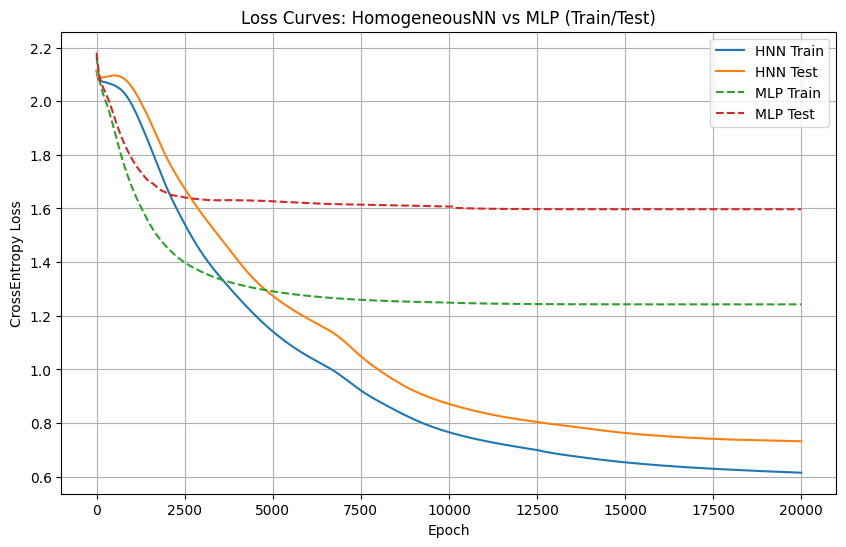

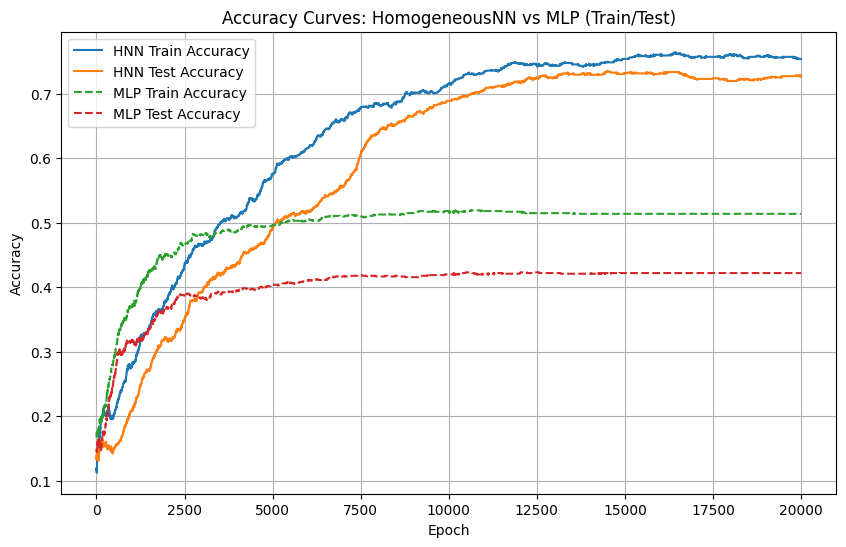

In [ ]:
# --- Device setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Prepare dataset ---
X = torch.tensor(df[feature_columns].values, dtype=torch.float32, device=device)
y = torch.tensor(df["label"].values, dtype=torch.long, device=device)

full_dataset = TensorDataset(X, y)

train_size = int(0.5 * len(df))
test_size = len(df) - train_size
train_ds, test_ds = random_split(full_dataset, [train_size, test_size])
batch_size = train_size

train_loader = DataLoader(train_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

# --- Compute normalization stats from training data ---
train_X, _ = next(iter(train_loader))
mean = train_X.mean(dim=0, keepdim=True)
std = train_X.std(dim=0, keepdim=True) + 1e-8

# --- Normalized DataLoader wrapper ---
class NormalizedLoaderWrapper:
    def __init__(self, loader, mean, std):
        self.loader = loader
        self.mean = mean
        self.std = std

    def __iter__(self):
        for x, y in self.loader:
            yield (self.normalize(x), y)

    def __len__(self):
        return len(self.loader)

    def normalize(self, x):
        return (x - self.mean) / self.std

train_loader_mlp = NormalizedLoaderWrapper(train_loader, mean, std)
test_loader_mlp = NormalizedLoaderWrapper(test_loader, mean, std)

# --- Model definitions ---
nu = 0.0
Gd = torch.diag(torch.tensor([3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0], device=device))
P = torch.eye(8, device=device)

hidden_dim = 8
output_dim = 8

model_hnn = HomogeneousNN(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim,
                          P=P, Gd=Gd, nu=nu).to(device)
model_hnn.apply(initialize_weights)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=8, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizers ---
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-3, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3, weight_decay=1e-4)

# --- Accuracy function ---
def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Training ---
num_epochs = 20000
train_loss_h, test_loss_h = [], []
train_loss_m, test_loss_m = [], []
train_acc_h, test_acc_h = [], []
train_acc_m, test_acc_m = [], []

for epoch in range(num_epochs):
    model_hnn.train()
    model_mlp.train()
    running_h, running_m = 0.0, 0.0

    for (x_hnn, y), (x_mlp, _) in zip(train_loader, train_loader_mlp):
        # HNN
        opt_hnn.zero_grad()
        pred_h = model_hnn(x_hnn)
        loss_h = criterion(pred_h, y)
        loss_h.backward()
        opt_hnn.step()
        running_h += loss_h.item()

        # MLP
        opt_mlp.zero_grad()
        pred_m = model_mlp(x_mlp)
        loss_m = criterion(pred_m, y)
        loss_m.backward()
        opt_mlp.step()
        running_m += loss_m.item()

    train_loss_h.append(running_h / len(train_loader))
    train_loss_m.append(running_m / len(train_loader))

    model_hnn.eval()
    model_mlp.eval()
    test_h, test_m = 0.0, 0.0

    with torch.no_grad():
        for bx, by in test_loader:
            test_h += criterion(model_hnn(bx), by).item()
        for bx, by in test_loader_mlp:
            test_m += criterion(model_mlp(bx), by).item()

    test_loss_h.append(test_h / len(test_loader))
    test_loss_m.append(test_m / len(test_loader))

    # Accuracies
    train_acc_h.append(compute_accuracy(model_hnn, train_loader))
    test_acc_h.append(compute_accuracy(model_hnn, test_loader))
    train_acc_m.append(compute_accuracy(model_mlp, train_loader_mlp))
    test_acc_m.append(compute_accuracy(model_mlp, test_loader_mlp))

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:4d} | HNN Train Loss: {train_loss_h[-1]:.4f} | Test Loss: {test_loss_h[-1]:.4f}"
              f" || MLP Train Loss: {train_loss_m[-1]:.4f} | Test Loss: {test_loss_m[-1]:.4f}")

print("Training complete.")

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_loss_h, label='HNN Train')
plt.plot(range(1, num_epochs+1), test_loss_h,  label='HNN Test')
plt.plot(range(1, num_epochs+1), train_loss_m, label='MLP Train', linestyle='--')
plt.plot(range(1, num_epochs+1), test_loss_m,  label='MLP Test',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy Loss')
plt.title('Loss Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Accuracy Curves ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_acc_h, label='HNN Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_h,  label='HNN Test Accuracy')
plt.plot(range(1, num_epochs+1), train_acc_m, label='MLP Train Accuracy', linestyle='--')
plt.plot(range(1, num_epochs+1), test_acc_m,  label='MLP Test Accuracy',  linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves: HomogeneousNN vs MLP (Train/Test)')
plt.legend()
plt.grid(True)
plt.show()